# Otimizando o modelo de 99% 

Esse notebook visa buscar melhorar o processamento do modelo proposto por [ahmadmustafa12](https://www.kaggle.com/code/ahmadmustafa12/transfer-learning-99-accuracy-tensorflow), buscando dinimuir a arquitetura e o tempo de processamento necessário para o modelo, mas mantendo uma boa acurácia

No modelo apresentado no notebook de exemplo, obteve-se uma acurácia de **92,64%** e um tempo de processamento de **7:52**


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
import os

In [2]:
trainpath = os.listdir("../../train")
testpath = os.listdir("../../test")

In [3]:
porcentagem_do_dataset = 1

In [4]:
train_data = trainpath[ :int(len(trainpath) * porcentagem_do_dataset) ]
test_data = testpath[ :int(len(testpath) * porcentagem_do_dataset) ]

In [5]:
print(len(train_data), len(test_data))

18000 3600


In [6]:
train_df = pd.DataFrame(train_data, columns=["Filepath"])
test_df = pd.DataFrame(test_data, columns=['Filepath'])

# train_df.apply( lambda x : x["Filepath"] = "../../train/" + x["Filepath"] ) 
train_df["Filepath"] = ( "../../train/" + train_df["Filepath"] ) 
test_df["Filepath"] = ( "../../test/" + test_df["Filepath"] ) 

In [7]:
train_df.head()

,Filepath
0,../../train/00048bba-979b-4f84-b833-5bbbb082b5...
1,../../train/000547a2-d456-4b16-b351-12ca9b40e3...
2,../../train/000cac8e-fcf0-4f8c-bd16-c257d1e6d7...
3,../../train/000d9961-8136-4dee-9820-86e1787779...
4,../../train/0010095b-2e3d-4517-a511-1f688c378f...


In [8]:
train_df['Label'] = train_df['Filepath'].apply(lambda a: a[-6:-4])
test_df['Label'] = test_df['Filepath'].apply(lambda a: a[-6:-4])

In [9]:
train_df.head()

,Filepath,Label
0,../../train/00048bba-979b-4f84-b833-5bbbb082b5...,0L
1,../../train/000547a2-d456-4b16-b351-12ca9b40e3...,0L
2,../../train/000cac8e-fcf0-4f8c-bd16-c257d1e6d7...,2L
3,../../train/000d9961-8136-4dee-9820-86e1787779...,0L
4,../../train/0010095b-2e3d-4517-a511-1f688c378f...,5L


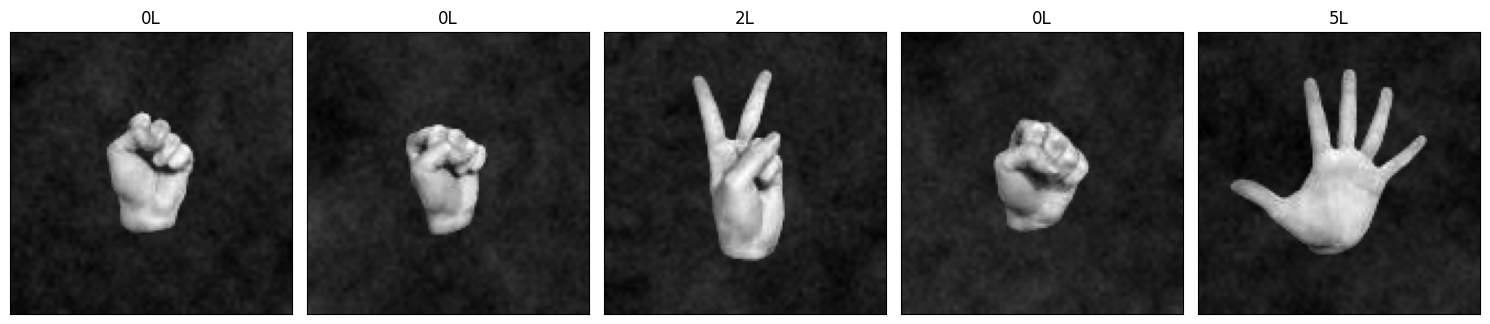

In [10]:
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(15, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(train_df.Filepath[i]), cmap='gray')
    ax.set_title(train_df.Label[i])
plt.tight_layout()
plt.show()

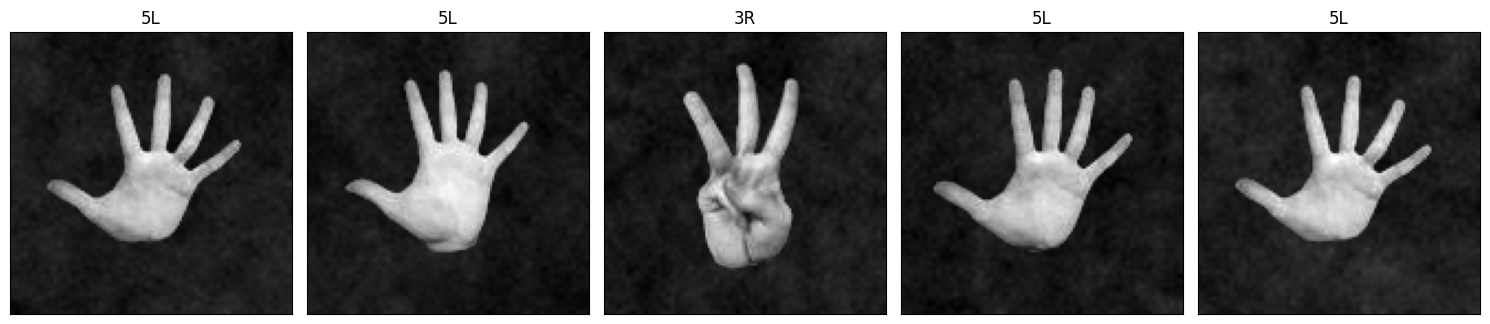

In [11]:
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(15, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(test_df.Filepath[i]), cmap='gray')
    ax.set_title(test_df.Label[i])
plt.tight_layout()
plt.show()

In [12]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input as preprocess_input_VGG16

In [13]:
TARGET_SIZE = (128, 128)

train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=preprocess_input_VGG16,
    validation_split=0.1
)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=preprocess_input_VGG16
)

train_images_flow = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=TARGET_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    subset='training',
    # validate_filenames=False
)

val_images_flow = train_generator.flow_from_dataframe( 
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=TARGET_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    subset='validation', 
    # validate_filenames=False
)

test_images_flow = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=TARGET_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False, 
    # validate_filenames=False
)

Found 16200 validated image filenames belonging to 12 classes.
Found 1800 validated image filenames belonging to 12 classes.
Found 3600 validated image filenames belonging to 12 classes.


In [14]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten

In [15]:
feature_extractor = VGG16(
    input_shape=(128, 128, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

feature_extractor.trainable = False

In [16]:
feature_extractor.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 128, 128, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 128, 128, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 64, 64, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 64, 64, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 32, 32, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 32, 32, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 32, 32, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 16, 16, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 16, 16, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 16, 16, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 16, 16, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 8, 8, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 8, 8, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 8, 8, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 8, 8, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 4, 4, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

In [17]:
classifier = Sequential([
    Dense(128, activation = 'relu'),
    Dense(12, activation ='softmax')
], name='Classifier')

In [18]:
complete_model = Sequential([
    feature_extractor,
    classifier
], name='CompleteModel')

In [19]:
#complete_model.build()
#tf.keras.utils.plot_model(complete_model, show_shapes=True)

In [20]:
complete_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [21]:
history = complete_model.fit(
    train_images_flow,
    validation_data=val_images_flow,
    batch_size = 32,
    epochs = 3,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=2,
            restore_best_weights=True
        )
    ]
)

Epoch 1/3


C:\Users\mauro\Desktop\Cursos\Atlantico Bootcamp - Machine Learning\avanti-ml-equipe-6\venv\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


507/507 ━━━━━━━━━━━━━━━━━━━━ 503s 989ms/step - accuracy: 0.7705 - loss: 0.8555 - val_accuracy: 0.9856 - val_loss: 0.0592
Epoch 2/3
507/507 ━━━━━━━━━━━━━━━━━━━━ 524s 1s/step - accuracy: 0.9849 - loss: 0.0547 - val_accuracy: 0.9906 - val_loss: 0.0356
Epoch 3/3
507/507 ━━━━━━━━━━━━━━━━━━━━ 525s 1s/step - accuracy: 0.9900 - loss: 0.0298 - val_accuracy: 0.9867 - val_loss: 0.0413


In [22]:
process_time = 61 + 56 + 56 
_minutes = process_time // 60 
_seconds = process_time % 60 
print(f"Tempo de processamento foi de {_minutes}:{_seconds}")

Tempo de processamento foi de 2:53


In [23]:
predictions = complete_model.predict(test_images_flow)

113/113 ━━━━━━━━━━━━━━━━━━━━ 98s 864ms/step


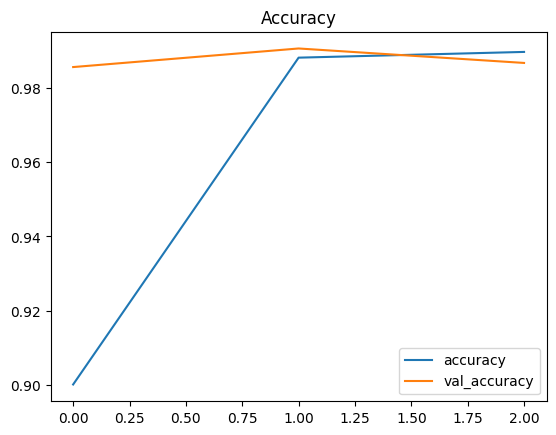

In [24]:
pd.DataFrame(history.history)[['accuracy','val_accuracy']].plot()
plt.title("Accuracy")
plt.show()

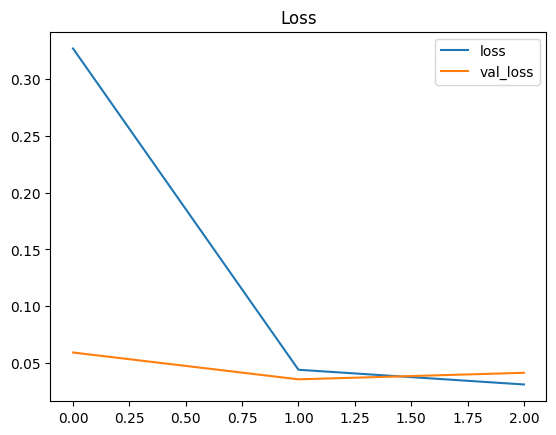

In [25]:
pd.DataFrame(history.history)[['loss','val_loss']].plot()
plt.title("Loss")
plt.show()

In [26]:
predictions

array([[1.89827425e-11, 1.57329330e-10, 3.70961779e-13, ...,
        1.08164329e-07, 9.99997616e-01, 1.93453070e-06],
       [6.33433236e-12, 1.92623491e-14, 2.22971157e-14, ...,
        1.09734513e-10, 9.99999404e-01, 6.51946209e-07],
       [7.96091221e-16, 3.82979537e-10, 3.57303313e-17, ...,
        3.08771064e-06, 1.74784286e-13, 1.28204780e-10],
       ...,
       [1.01565264e-14, 2.38214315e-09, 6.78526754e-16, ...,
        9.99993563e-01, 2.68968154e-08, 3.79681381e-07],
       [5.32974598e-09, 2.90322902e-07, 8.39022241e-10, ...,
        3.03736147e-06, 4.15261558e-09, 7.43907691e-08],
       [5.22123678e-09, 1.71188788e-06, 6.72202127e-10, ...,
        6.90841844e-05, 2.37823308e-08, 6.17291448e-07]], dtype=float32)

In [27]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [28]:
HAND_MAP_ID = test_df["Label"].unique() #['0L', '1L', '2L', '3L', '4L', '5L', '0R', '1R', '2R', '3R', '4R', '5R']
HAND_MAP_ID = sorted(list(HAND_MAP_ID))
print(HAND_MAP_ID)

['0L', '0R', '1L', '1R', '2L', '2R', '3L', '3R', '4L', '4R', '5L', '5R']


In [29]:
test_labels_indices = [HAND_MAP_ID.index(label) for label in test_df["Label"]]

test_labels = np.array( test_labels_indices )
print(len(test_labels))

3600


In [30]:
y_pred = np.argmax(predictions, axis=1)
# print(y_pred)
# print(test_labels)
conf_matrix = confusion_matrix(y_pred, test_labels)

In [31]:
print(conf_matrix)

[[299  28   0   0   0   0   0   0   0   0   0   0]
 [  1 272   0   0   0   0   0   0   0   0   0   0]
 [  0   0 300   5   0   0   0   0   0   0   0   0]
 [  0   0   0 295   1   0   0   0   0   0   0   0]
 [  0   0   0   0 298   2   0   0   0   0   0   0]
 [  0   0   0   0   1 298   0   0   0   0   0   0]
 [  0   0   0   0   0   0 299   0   0   0   0   0]
 [  0   0   0   0   0   0   1 300   0   0   0   0]
 [  0   0   0   0   0   0   0   0 299   0   0   0]
 [  0   0   0   0   0   0   0   0   1 300   0   0]
 [  0   0   0   0   0   0   0   0   0   0 300   0]
 [  0   0   0   0   0   0   0   0   0   0   0 300]]


In [32]:
num_acertos = 0 

for i in range(12):
    num_acertos += conf_matrix[i, i]

print(num_acertos / len(predictions) )

0.9888888888888889


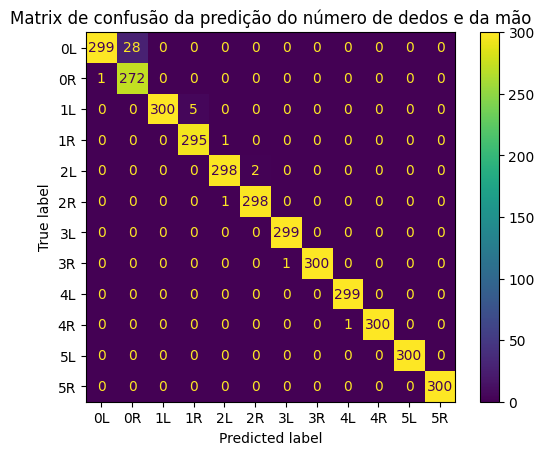

In [33]:
labels = HAND_MAP_ID

disp = ConfusionMatrixDisplay(
    confusion_matrix = conf_matrix, 
    display_labels = labels)
disp.plot()
plt.title("Matrix de confusão da predição do número de dedos e da mão")
plt.show()

### Salvando modelo : 

In [35]:
print("Modelo salvo na pasta entrega 3 :")
complete_model.save("../../Entrega 3/cnn-99.keras")

Modelo salvo na pasta entrega 3 :
